In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
#from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


In [4]:
normal_pump_path="/home/woody/iwso/iwso122h/Calf_Detection/Audio/Audio_Work_AE/normal_calf_subset"
abnormal_pump_path="/home/woody/iwso/iwso122h/Calf_Detection/Audio/Audio_Work_AE/abnormal_subset"


def load_audio_files(path, label):
    audio_files = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.wav'):
            file_path = os.path.join(path, filename)
            audio, sample_rate = librosa.load(file_path, sr=None)
            audio_files.append(audio)
            labels.append(label)
    return audio_files, labels, sample_rate

# Load the datasets
abnormal_audio, abnormal_labels, _ = load_audio_files(abnormal_pump_path, label=1)
normal_audio, normal_labels, sample_rate = load_audio_files(normal_pump_path, label=0)


In [5]:
# Feature Extraction:

# MFCCs (Power Spectrum)
def extract_mfccs(audio, sample_rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

# Spectral Features (spectral centroid, spectral roll-off, and spectral contrast):
def extract_spectral_features(audio, sample_rate):
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)[0]
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)[0]
    return np.mean(spectral_centroids), np.mean(spectral_rolloff), np.mean(spectral_contrast)

# Temporal Features ( zero-crossing rate and autocorrelation):
def extract_temporal_features(audio):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    autocorrelation = librosa.autocorrelate(audio)
    return np.mean(zero_crossing_rate), np.mean(autocorrelation)


In [6]:
# Data Augmentation:
def augment_audio(audio, sample_rate, noise_factor=0.005, shift_max=0.2):
    # Should experiment with Time Shifting
    # shift = np.random.randint(int(sample_rate * shift_max))
    # augmented_audio = np.roll(audio, shift)
    augmented_audio = audio

    # Should experiment with Adding Noise
    noise = np.random.randn(len(augmented_audio))
    augmented_audio = augmented_audio + noise_factor * noise

    return augmented_audio

In [7]:
# Feature Extraction:

def extract_features(audio_data, sample_rate):
    features = []
    for audio in audio_data:
        mfccs = extract_mfccs(audio, sample_rate)
        spectral_features = extract_spectral_features(audio, sample_rate)
        temporal_features = extract_temporal_features(audio)
        all_features = np.concatenate([mfccs, spectral_features, temporal_features])
        features.append(all_features)
    return np.array(features)

# Extract features for both normal and abnormal data
normal_features = extract_features(normal_audio, sample_rate)
abnormal_features = extract_features(abnormal_audio, sample_rate)



In [8]:
# 13 MFCCs
n_mfcc = 13 
mfcc_labels = [f'MFCC_{i+1}' for i in range(n_mfcc)]

# 3 Spectral features
spectral_labels = ['Spectral Centroid', 'Spectral Rolloff', 'Spectral Contrast']

# 2 temporal features
temporal_labels = ['Zero Crossing Rate', 'Autocorrelation']

# Combining all feature labels into a single list
feature_names = mfcc_labels + spectral_labels + temporal_labels

feature_names

['MFCC_1',
 'MFCC_2',
 'MFCC_3',
 'MFCC_4',
 'MFCC_5',
 'MFCC_6',
 'MFCC_7',
 'MFCC_8',
 'MFCC_9',
 'MFCC_10',
 'MFCC_11',
 'MFCC_12',
 'MFCC_13',
 'Spectral Centroid',
 'Spectral Rolloff',
 'Spectral Contrast',
 'Zero Crossing Rate',
 'Autocorrelation']

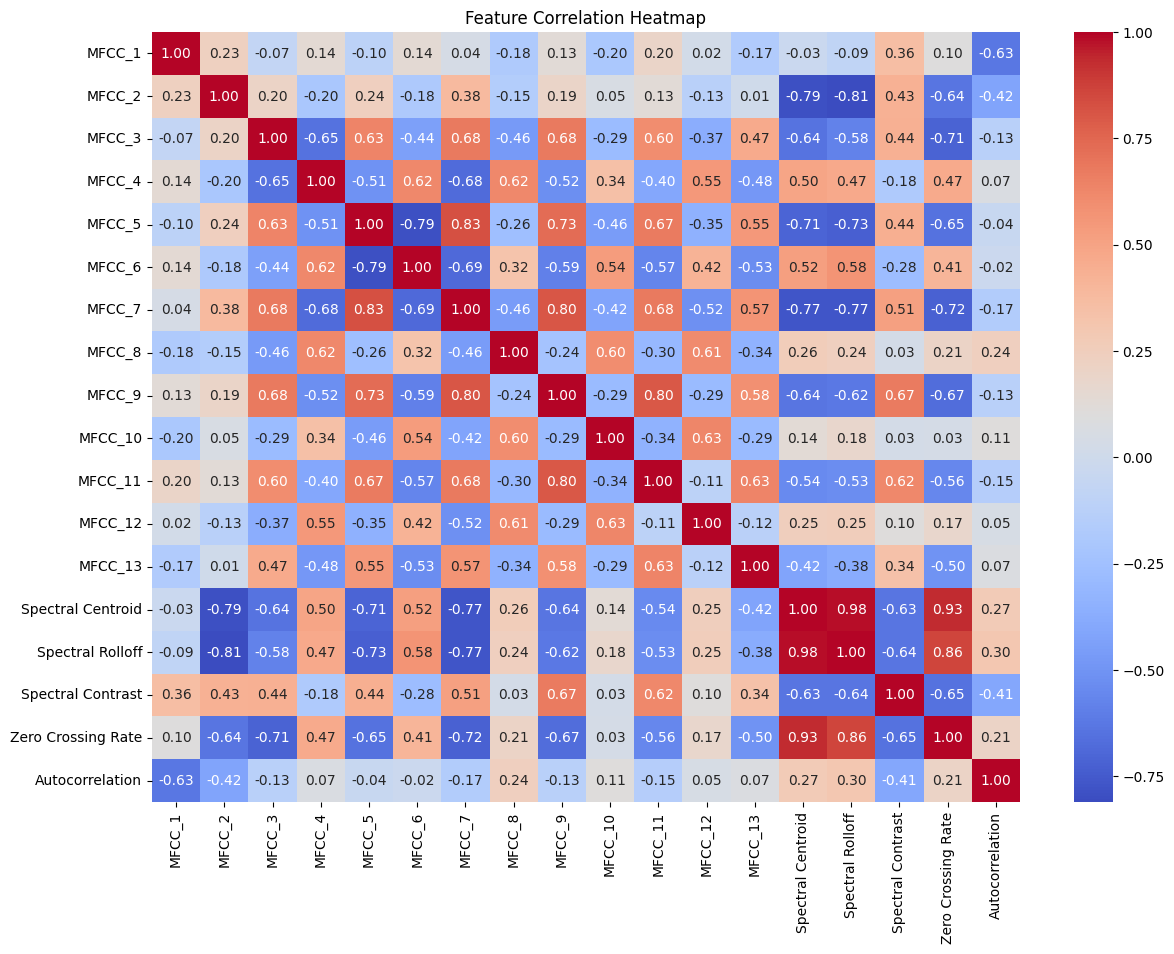

In [9]:
# Feature Correlations
import seaborn as sns

# Assuming 'features' is a combined array of normal and abnormal features
features = np.concatenate((normal_features, abnormal_features))

# Calculate the correlation matrix
corr_matrix = np.corrcoef(features.T)  # Transpose to get features as columns

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=feature_names, yticklabels=feature_names)
plt.title('Feature Correlation Heatmap')
plt.show()


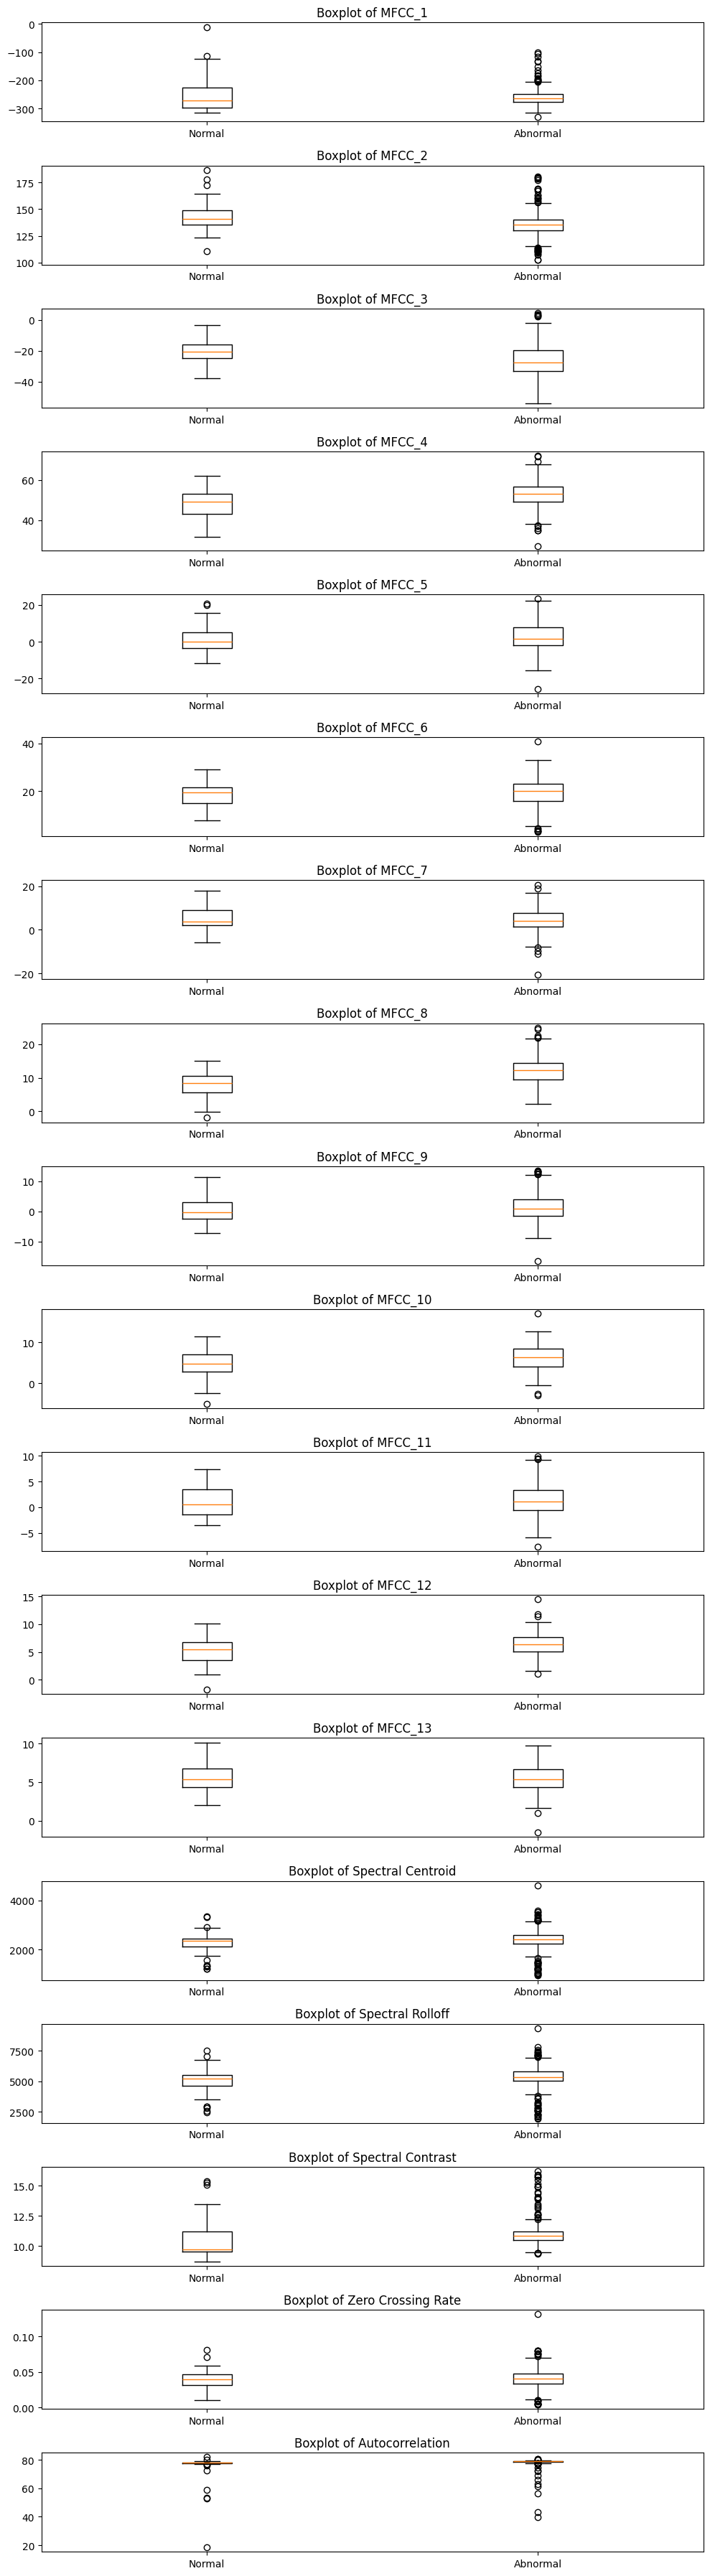

In [10]:
# Comparing Normal and Abnormal Features.
import matplotlib.pyplot as plt

# Boxplot for visualizing the distributions
def plot_feature_boxplots(normal_features, abnormal_features, feature_names):
    number_of_features = normal_features.shape[1]
    fig = plt.figure(figsize=(10, 2 * number_of_features))

    for i in range(number_of_features):
        ax = fig.add_subplot(number_of_features, 1, i + 1)
        ax.boxplot([normal_features[:, i], abnormal_features[:, i]], labels=['Normal', 'Abnormal'])
        ax.set_title(f'Boxplot of {feature_names[i]}')

    plt.tight_layout()
    plt.show()



plot_feature_boxplots(normal_features, abnormal_features, feature_names)


In [11]:
# Stastical Analysis

# Calculate mean and standard deviation for all features
for i in range(normal_features.shape[1]):
    normal_mean = np.mean(normal_features[:, i])
    normal_std = np.std(normal_features[:, i])
    abnormal_mean = np.mean(abnormal_features[:, i])
    abnormal_std = np.std(abnormal_features[:, i])
    feature = feature_names[i] 
    print(feature)
    print(f"- Normal - Mean: {normal_mean:.2f}, Std Dev: {normal_std:.2f}")
    print(f"- Abnormal - Mean: {abnormal_mean:.2f}, Std Dev: {abnormal_std:.2f}")
    print()  # Print a new line for better readability


MFCC_1
- Normal - Mean: -252.89, Std Dev: 56.98
- Abnormal - Mean: -259.25, Std Dev: 29.98

MFCC_2
- Normal - Mean: 142.36, Std Dev: 13.06
- Abnormal - Mean: 135.81, Std Dev: 11.19

MFCC_3
- Normal - Mean: -20.71, Std Dev: 7.98
- Abnormal - Mean: -26.05, Std Dev: 10.00

MFCC_4
- Normal - Mean: 48.65, Std Dev: 6.79
- Abnormal - Mean: 52.66, Std Dev: 6.43

MFCC_5
- Normal - Mean: 1.20, Std Dev: 7.05
- Abnormal - Mean: 2.49, Std Dev: 7.71

MFCC_6
- Normal - Mean: 18.88, Std Dev: 5.02
- Abnormal - Mean: 19.38, Std Dev: 5.73

MFCC_7
- Normal - Mean: 5.32, Std Dev: 5.54
- Abnormal - Mean: 4.55, Std Dev: 5.20

MFCC_8
- Normal - Mean: 8.07, Std Dev: 3.65
- Abnormal - Mean: 12.06, Std Dev: 3.84

MFCC_9
- Normal - Mean: 0.38, Std Dev: 4.34
- Abnormal - Mean: 1.27, Std Dev: 4.07

MFCC_10
- Normal - Mean: 4.61, Std Dev: 3.15
- Abnormal - Mean: 6.23, Std Dev: 2.96

MFCC_11
- Normal - Mean: 1.05, Std Dev: 2.94
- Abnormal - Mean: 1.42, Std Dev: 2.74

MFCC_12
- Normal - Mean: 5.12, Std Dev: 2.35
- Abn

In [12]:
# Statistical Significance Tests

from scipy.stats import ttest_ind

# Perform t-tests for all features
for i in range(normal_features.shape[1]):
    t_stat, p_val = ttest_ind(normal_features[:, i], abnormal_features[:, i])
    
    # Assuming you have a list of feature names
    feature_name = feature_names[i]
    
    # Print the t-statistic and p-value for each feature
    print(f"{feature_name}:")
    print(f"  T-Stat = {t_stat:.3f}, P-value = {p_val:.3g}")
    print()


MFCC_1:
  T-Stat = 1.298, P-value = 0.195

MFCC_2:
  T-Stat = 4.090, P-value = 5.18e-05

MFCC_3:
  T-Stat = 3.923, P-value = 0.000102

MFCC_4:
  T-Stat = -4.426, P-value = 1.23e-05

MFCC_5:
  T-Stat = -1.216, P-value = 0.225

MFCC_6:
  T-Stat = -0.625, P-value = 0.532

MFCC_7:
  T-Stat = 1.046, P-value = 0.296

MFCC_8:
  T-Stat = -7.485, P-value = 4.25e-13

MFCC_9:
  T-Stat = -1.553, P-value = 0.121

MFCC_10:
  T-Stat = -3.872, P-value = 0.000125

MFCC_11:
  T-Stat = -0.948, P-value = 0.344

MFCC_12:
  T-Stat = -4.736, P-value = 2.99e-06

MFCC_13:
  T-Stat = 0.687, P-value = 0.492

Spectral Centroid:
  T-Stat = -1.943, P-value = 0.0527

Spectral Rolloff:
  T-Stat = -1.707, P-value = 0.0886

Spectral Contrast:
  T-Stat = -3.763, P-value = 0.000192

Zero Crossing Rate:
  T-Stat = -0.970, P-value = 0.333

Autocorrelation:
  T-Stat = -3.989, P-value = 7.82e-05



In [13]:
# Model Development and Evaluation:

# normal_features and abnormal_features should be preprocessed for feature arrays ( Keep in mind !!)
X_train, X_val = train_test_split(normal_features, test_size=0.2)
X_test = abnormal_features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Combine normal and abnormal data
X_combined_test = np.concatenate((X_val_scaled, X_test_scaled))
y_combined_test = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_test_scaled))))  # 0 for normal, 1 for abnormal

In [14]:
def enhanced_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoder = Dense(128, activation='relu')(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(64, activation='relu')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(32, activation='relu')(encoder)

    # Decoder
    decoder = Dense(64, activation='relu')(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    decoder = Dense(128, activation='relu')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
from tensorflow.keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed, BatchNormalization, Dropout, Activation


def enhanced_autoencoder_with_lstm(input_dim, timesteps, n_features):
    input_layer = Input(shape=(timesteps, n_features))

    # Encoder with LSTM
    encoder = LSTM(128, activation='relu', return_sequences=True)(input_layer)
    encoder = LSTM(64, activation='relu', return_sequences=False)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)

    # Repeat Vector
    repeat_vector = RepeatVector(timesteps)(encoder)

    # Decoder with LSTM
    decoder = LSTM(64, activation='relu', return_sequences=True)(repeat_vector)
    decoder = LSTM(128, activation='relu', return_sequences=True)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    output_layer = TimeDistributed(Dense(n_features, activation='sigmoid'))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

X_train, X_val = train_test_split(normal_features, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Print the shape of your data
print("Shape of X_train_scaled:", X_train_scaled.shape)

# Calculate the total number of elements
total_elements = np.prod(X_train_scaled.shape)
print("Total number of elements:", total_elements)

n_samples, n_features = X_train_scaled.shape

# Find suitable timesteps
for timesteps in range(1, n_samples + 1):
    if n_samples % timesteps == 0:
        reshaped_samples = n_samples // timesteps
        if reshaped_samples * timesteps * n_features == n_samples * n_features:
            print(f"Suitable timesteps: {timesteps}")
            break

# Reshaping for LSTM Input
timesteps = 1  # Should be adjusted as we scale.
n_features = normal_features.shape[1]
X_train_reshaped = X_train_scaled.reshape((-1, timesteps, n_features))
X_val_reshaped = X_val_scaled.reshape((-1, timesteps, n_features))

# Model Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder = enhanced_autoencoder_with_lstm(input_dim=n_features, timesteps=timesteps, n_features=n_features)
autoencoder.fit(
    X_train_reshaped, X_train_reshaped,
    epochs=400,
    batch_size=256,
    validation_data=(X_val_reshaped, X_val_reshaped),
    callbacks=[early_stopping],
    verbose=1
)

Shape of X_train_scaled: (48, 18)
Total number of elements: 864
Suitable timesteps: 1


2024-04-04 15:21:51.625353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8245 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-04-04 15:21:53.162270: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/400


2024-04-04 15:22:00.308559: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8f12c8e6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 15:22:00.308591: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-04 15:22:00.423311: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-04 15:22:00.475360: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1712236920.589490 3832015 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 9s 9s/step - loss: 1.2494 - val_loss: 0.9300
Epoch 2/400
1/1 [==============================] - 0s 58ms/step - loss: 1.2394 - val_loss: 0.9290
Epoch 3/400
1/1 [==============================] - 0s 61ms/step - loss: 1.2297 - val_loss: 0.9279
Epoch 4/400
1/1 [==============================] - 0s 58ms/step - loss: 1.2177 - val_loss: 0.9268
Epoch 5/400
1/1 [==============================] - 0s 54ms/step - loss: 1.2073 - val_loss: 0.9258
Epoch 6/400
1/1 [==============================] - 0s 56ms/step - loss: 1.1907 - val_loss: 0.9247
Epoch 7/400
1/1 [==============================] - 0s 53ms/step - loss: 1.1708 - val_loss: 0.9235
Epoch 8/400
1/1 [==============================] - 0s 56ms/step - loss: 1.1545 - val_loss: 0.9224
Epoch 9/400
1/1 [==============================] - 0s 56ms/step - loss: 1.1321 - val_loss: 0.9213
Epoch 10/400
1/1 [==============================] - 0s 59ms/step - loss: 1.1070 - val_loss: 0.9201
Epoch 11/400
1/1 [===============

In [16]:
def model_training(X_train_scaled, X_val_scaled):
    # Adjust input_dim based on your feature dimensions
    input_dim = X_train_scaled.shape[1]
    autoencoder = enhanced_autoencoder(input_dim)
    # autoencoder = lstm_autoencoder(input_dim, timesteps=1, n_features=input_dim)
    autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=400,  # Experiment with different epochs
    batch_size=256,
    shuffle=True,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stopping],
    verbose=1
    )
    return autoencoder

In [17]:
def model_evaluation(autoencoder,X_combined_test):
    reconstructed_combined = autoencoder.predict(X_combined_test)
    mse_combined = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=1)
    precisions, recalls, thresholds = precision_recall_curve(y_combined_test, mse_combined)
    # Calculate precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_combined_test, mse_combined)

    # Calculate F1 score for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # Use the optimal threshold to define anomalies
    optimal_predictions = (mse_combined > optimal_threshold).astype(int)

    # Calculate metrics using the optimal threshold
    optimal_accuracy = accuracy_score(y_combined_test, optimal_predictions)
    optimal_precision = precision_score(y_combined_test, optimal_predictions)
    optimal_recall = recall_score(y_combined_test, optimal_predictions)
    optimal_f1 = f1_score(y_combined_test, optimal_predictions)

    # Print metrics using the optimal threshold
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Accuracy: {optimal_accuracy}")
    print(f"Precision: {optimal_precision}")
    print(f"Recall: {optimal_recall}")
    print(f"F1 Score: {optimal_f1}")

    # Plot confusion matrix using the optimal threshold
    optimal_cm = confusion_matrix(y_combined_test, optimal_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Optimal Confusion Matrix')
    plt.show()

Epoch 1/400
1/1 [==============================] - 3s 3s/step - loss: 1.2958 - val_loss: 0.9346
Epoch 2/400
1/1 [==============================] - 0s 41ms/step - loss: 1.2838 - val_loss: 0.9328
Epoch 3/400
1/1 [==============================] - 0s 45ms/step - loss: 1.2364 - val_loss: 0.9310
Epoch 4/400
1/1 [==============================] - 0s 48ms/step - loss: 1.2337 - val_loss: 0.9293
Epoch 5/400
1/1 [==============================] - 0s 50ms/step - loss: 1.2162 - val_loss: 0.9275
Epoch 6/400
1/1 [==============================] - 0s 48ms/step - loss: 1.1721 - val_loss: 0.9255
Epoch 7/400
1/1 [==============================] - 0s 47ms/step - loss: 1.1481 - val_loss: 0.9234
Epoch 8/400
1/1 [==============================] - 0s 48ms/step - loss: 1.1127 - val_loss: 0.9211
Epoch 9/400
1/1 [==============================] - 0s 50ms/step - loss: 1.0957 - val_loss: 0.9187
Epoch 10/400
1/1 [==============================] - 0s 47ms/step - loss: 1.0942 - val_loss: 0.9163
Epoch 11/400
1/1 [===

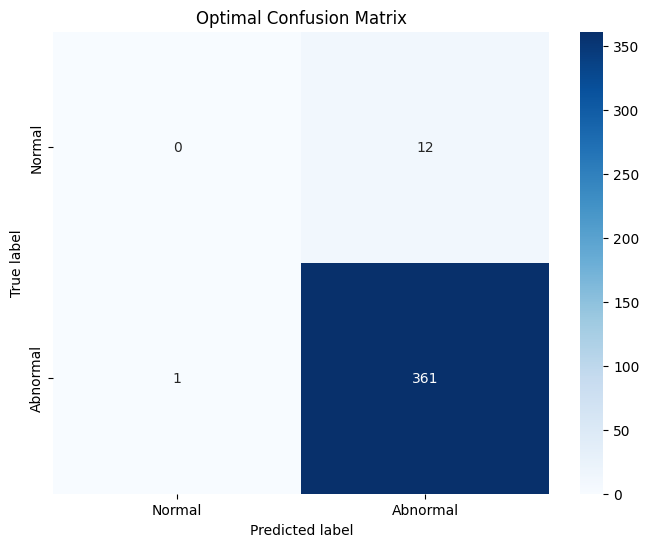

In [18]:
autoencoder = model_training(X_train_scaled, X_val_scaled)
model_evaluation(autoencoder,X_combined_test)

In [19]:
autoencoder.save('Encoder_Model.keras')

In [20]:
# Predict the reconstructed sounds for the combined test set
reconstructed_combined = autoencoder.predict(X_combined_test)

# Calculate the mean squared reconstruction error for each feature
mse_features = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=0)

# Rank features by reconstruction error
feature_importance_ranking = np.argsort(mse_features)[::-1]  # Features with the highest error first


# Print out the feature ranking with feature names
print("Feature importance ranking (from most to least important):")
for rank in feature_importance_ranking:
    print(f"{feature_names[rank]}: MSE = {mse_features[rank]}")

12/12 [==============================] - 0s 2ms/step


Feature importance ranking (from most to least important):
MFCC_3: MSE = 1.7709568148676764
MFCC_8: MSE = 0.9549507461103697
MFCC_2: MSE = 0.7634292791179859
MFCC_6: MSE = 0.6892187901854212
MFCC_13: MSE = 0.6518601943116845
MFCC_5: MSE = 0.6331764505233387
MFCC_7: MSE = 0.6156247036889267
Zero Crossing Rate: MSE = 0.6054047117793974
Spectral Centroid: MSE = 0.5385094210563723
MFCC_11: MSE = 0.4960309490038359
MFCC_9: MSE = 0.47578655404761705
MFCC_10: MSE = 0.4729738755893112
Spectral Rolloff: MSE = 0.4601302346915209
MFCC_4: MSE = 0.4098435862170016
MFCC_12: MSE = 0.282918701364544
MFCC_1: MSE = 0.2685769954014859
Spectral Contrast: MSE = 0.20316946634933308
Autocorrelation: MSE = 0.09666391045967078


In [21]:
# Extra Feature Extraction:

def extract_additional_features(audio, sample_rate):
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
    spec_flatness = librosa.feature.spectral_flatness(y=audio)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
    rms = librosa.feature.rms(y=audio)
    
    return np.mean(chroma_stft), np.mean(spec_bw), np.mean(spec_flatness), np.mean(rolloff), np.mean(rms)

def extract_features(audio_data, sample_rate):
    features = []
    for audio in audio_data:
        mfccs = extract_mfccs(audio, sample_rate)
        spectral_features = extract_spectral_features(audio, sample_rate)
        temporal_features = extract_temporal_features(audio)
        additional_features = extract_additional_features(audio, sample_rate)
        all_features = np.concatenate([mfccs, spectral_features, temporal_features, additional_features])
        features.append(all_features)
    return np.array(features)

# Extract features for both normal and abnormal data
normal_features = extract_features(normal_audio, sample_rate)
abnormal_features = extract_features(abnormal_audio, sample_rate)

In [ ]:
normal_features.shape

(60, 23)

In [ ]:
# Adding additional features to features list
additional_features = ['Chroma Features', 'Spectral Bandwidth', 'Spectral Flatness', 'Spectral Roll-off Frequency', 'Root Mean Square Energy']

# Combine all feature labels into a single list
feature_names = feature_names + additional_features
feature_names

['MFCC_1',
 'MFCC_2',
 'MFCC_3',
 'MFCC_4',
 'MFCC_5',
 'MFCC_6',
 'MFCC_7',
 'MFCC_8',
 'MFCC_9',
 'MFCC_10',
 'MFCC_11',
 'MFCC_12',
 'MFCC_13',
 'Spectral Centroid',
 'Spectral Rolloff',
 'Spectral Contrast',
 'Zero Crossing Rate',
 'Autocorrelation',
 'Chroma Features',
 'Spectral Bandwidth',
 'Spectral Flatness',
 'Spectral Roll-off Frequency',
 'Root Mean Square Energy']

In [ ]:
X_train, X_val = train_test_split(normal_features, test_size=0.2)
X_test = abnormal_features

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Combine normal and abnormal data
X_combined_test = np.concatenate((X_val_scaled, X_test_scaled))
y_combined_test = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_test_scaled))))  # 0 for normal, 1 for abnormal

12/12 [==============================] - 0s 2ms/step
Optimal Threshold: 0.062389682272355036
Accuracy: 0.9652406417112299
Precision: 0.967828418230563
Recall: 0.9972375690607734
F1 Score: 0.9823129251700681


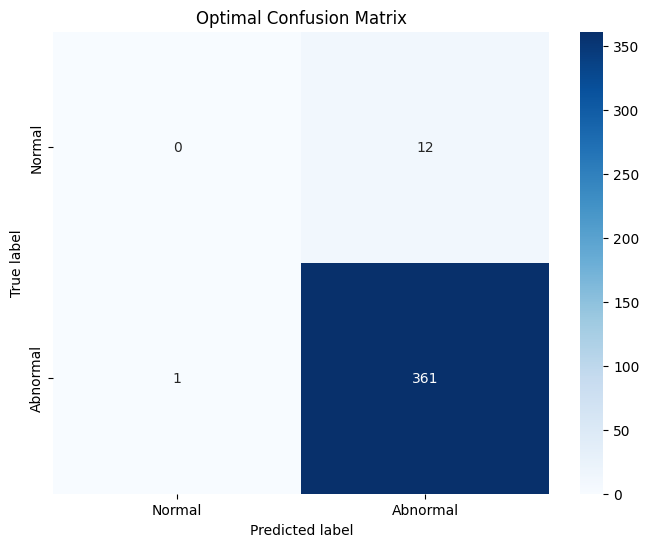

In [ ]:
autoencoder = model_training(X_train_scaled, X_val_scaled)
model_evaluation(autoencoder,X_combined_test)

In [ ]:
autoencoder.save('Encoder_Model2.keras')

In [ ]:
# Predict the reconstructed sounds for the combined test set
reconstructed_combined = autoencoder.predict(X_combined_test)

# Calculate the mean squared reconstruction error for each feature
mse_features = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=0)

# Rank features by reconstruction error
feature_importance_ranking = np.argsort(mse_features)[::-1]  # Features with the highest error first

# Print out the feature ranking with feature names
print("Feature importance ranking (from most to least important):")
for rank in feature_importance_ranking:
    print(f"{feature_names[rank]}: MSE = {mse_features[rank]}")

12/12 [==============================] - 0s 2ms/step
Feature importance ranking (from most to least important):
MFCC_3: MSE = 1.3775772727690205
MFCC_8: MSE = 1.0971422207234236
MFCC_6: MSE = 0.8926657260220126
MFCC_2: MSE = 0.7915251701637551
Zero Crossing Rate: MSE = 0.6489993014808202
MFCC_10: MSE = 0.6067676377372583
MFCC_7: MSE = 0.598988126197159
Spectral Centroid: MSE = 0.5976796187700127
MFCC_5: MSE = 0.5958569107250182
MFCC_13: MSE = 0.5954088346584115
Spectral Flatness: MSE = 0.5402397417369692
Spectral Roll-off Frequency: MSE = 0.5399041251193822
Spectral Rolloff: MSE = 0.538198202662672
Spectral Bandwidth: MSE = 0.4907069173265609
MFCC_11: MSE = 0.48699020319862996
MFCC_9: MSE = 0.4734519434399144
MFCC_4: MSE = 0.4464835125453384
MFCC_1: MSE = 0.3140874884789297
Spectral Contrast: MSE = 0.3023618874057797
MFCC_12: MSE = 0.27842939551925044
Root Mean Square Energy: MSE = 0.25217738528468603
Chroma Features: MSE = 0.22657297956514635
Autocorrelation: MSE = 0.14527195242002686

In [ ]:
# Select the top N features
N = 10  # By trying different values
top_features_indices = feature_importance_ranking[:N]
top_features=[]
for rank in feature_importance_ranking[:N]:
    top_features.append(feature_names[rank])

top_features

['MFCC_3',
 'MFCC_8',
 'MFCC_6',
 'MFCC_2',
 'Zero Crossing Rate',
 'MFCC_10',
 'MFCC_7',
 'Spectral Centroid',
 'MFCC_5',
 'MFCC_13']

In [ ]:
# Subset the features for both normal and abnormal data
normal_features_subset = normal_features[:, top_features_indices]
abnormal_features_subset = abnormal_features[:, top_features_indices]

# Split and scale the data as before
X_train_subset, X_val_subset = train_test_split(normal_features_subset, test_size=0.2)
X_test_subset = abnormal_features_subset

scaler_subset = StandardScaler()
X_train_subset_scaled = scaler_subset.fit_transform(X_train_subset)
X_val_subset_scaled = scaler_subset.transform(X_val_subset)
X_test_subset_scaled = scaler_subset.transform(X_test_subset)

# Combine normal and abnormal data
X_combined_test = np.concatenate((X_val_subset_scaled, X_test_subset_scaled))
y_combined_test = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_test_scaled))))  # 0 for normal, 1 for abnormal

12/12 [==============================] - 0s 2ms/step
Optimal Threshold: 0.04606945702799042
Accuracy: 0.9652406417112299
Precision: 0.967828418230563
Recall: 0.9972375690607734
F1 Score: 0.9823129251700681


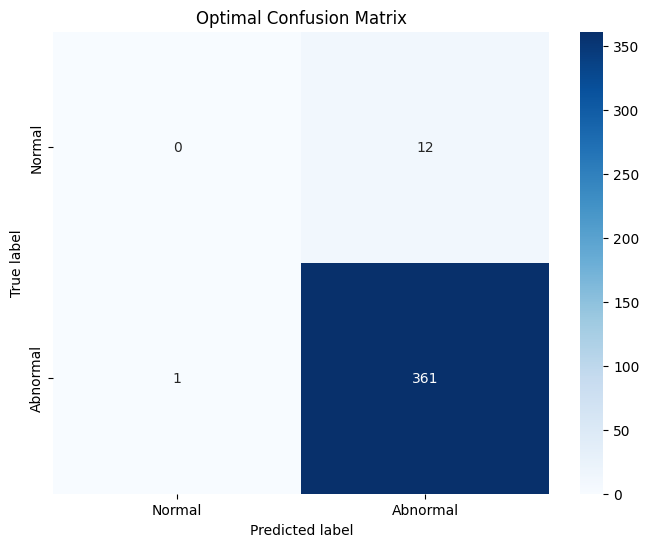

In [ ]:
autoencoder2 = model_training(X_train_subset_scaled, X_val_subset_scaled)
model_evaluation(autoencoder2,X_combined_test)

In [ ]:
# Predict the reconstructed sounds for the combined test set
reconstructed_combined = autoencoder2.predict(X_combined_test)

# Calculate the mean squared reconstruction error for each feature
mse_features = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=0)

# Rank features by reconstruction error
feature_importance_ranking = np.argsort(mse_features)[::-1]  # Features with the highest error first


# Print out the feature ranking with feature names
print("Feature importance ranking (from most to least important):")
for rank in feature_importance_ranking:
    print(f"{top_features[rank]}: MSE = {mse_features[rank]}")

12/12 [==============================] - 0s 2ms/step
Feature importance ranking (from most to least important):
MFCC_3: MSE = 1.5514401577153714
MFCC_2: MSE = 1.0237061797298004
MFCC_8: MSE = 0.8695891282981415
Spectral Centroid: MSE = 0.863556651253688
Zero Crossing Rate: MSE = 0.8042733021852143
MFCC_6: MSE = 0.7159858663320949
MFCC_5: MSE = 0.6866890928535302
MFCC_7: MSE = 0.5963066726046371
MFCC_13: MSE = 0.5472374242106589
MFCC_10: MSE = 0.44691631028963086


In [ ]:
autoencoder2.save('Encoder_Model3.keras')

In [ ]:
from scipy.stats import ttest_ind

# Perform t-tests for all features
for i in range(normal_features.shape[1]):
    t_stat, p_val = ttest_ind(normal_features[:, i], abnormal_features[:, i])
    
    # Assuming you have a list of feature names
    feature_name = feature_names[i]
    
    # Print the t-statistic and p-value for each feature
    print(f"{feature_name}:")
    print(f"  T-Stat = {t_stat:.3f}, P-value = {p_val:.3g}")
    print()
